First, train a very simple neural network on the MNIST dataset with only basic PyTorch Tensor functionality. Gradually, add other features *torch.nn, torch.optim, Dataset, DataLoader*.

## MNIST data setup

Using *pathlib* to deal with paths. And downloading the dataset using *requests*.

In [1]:
from pathlib import Path
import requests

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

In [3]:
PATH.mkdir(parents=True, exist_ok=True)

In [4]:
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

The dataset is in numpy array format and has been stored as pickle, python specific format for serializing data.

In [5]:
import pickle
import gzip

In [6]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28x28 and is stored as a flatenned row of length 784.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.Size([50000, 784])


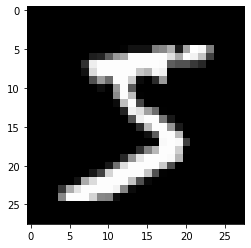

In [15]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

PyTorch uses torch.tensor rather than numpy arrays. Hence converting them to Tensors

In [16]:
import torch

In [17]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                         (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape

<ipython-input-17-67aa3f0a8b94>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(torch.tensor,


In [18]:
n, c

(50000, 784)

In [19]:
print(x_train, y_train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])


In [20]:
print(x_train.shape, y_train.shape)

torch.Size([50000, 784]) torch.Size([50000])


In [21]:
print(y_train.min(), y_train.max())

tensor(0) tensor(9)


## Neural Net from Scratch

Fitting a model using only PyTorch tensor operations.

- Initialize weights and bias with zero-filled or random tensors

- They have an extra feature which is *requires_grad*. If it is set to True then PyTorch records all the operations done on tensor so that it can calculate the gradient during backward pass automatically!

- For the weights *required_grad=True* is set after initialization since we don't need that step included in the gradient.

*Note that a trailing _ in PyTorch means the operation is performed in-place.*

> The weights are initialized here with *Xavier initialization* *by multiplying with 1/sqrt(n)).

In [22]:
import math

In [23]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [24]:
weights

tensor([[ 1.5814e-04, -8.5598e-03,  2.7338e-02,  ...,  2.7724e-02,
          2.9955e-02, -5.6143e-02],
        [-7.7507e-05, -1.0433e-01, -2.5837e-02,  ...,  4.2621e-02,
          1.4141e-02,  2.7683e-02],
        [ 4.4182e-02, -2.0979e-03,  1.6336e-02,  ..., -3.4391e-02,
          2.2183e-02,  4.2972e-02],
        ...,
        [-2.3328e-03, -4.8156e-03, -2.5938e-02,  ..., -1.0651e-02,
          6.8579e-02,  6.7554e-02],
        [-8.2254e-03, -9.3074e-03, -6.3071e-02,  ...,  1.2700e-02,
          7.2377e-02,  3.0634e-02],
        [-4.4982e-02, -3.2006e-02,  1.8981e-02,  ...,  1.5722e-02,
         -2.6541e-02, -3.1581e-02]], requires_grad=True)

In [26]:
# defining log_softmax activation function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)        # @ : dot product

Calling function only on one batch of data (i.e. 64 images), which is one *forward pass*. So the predictions won't be any better than random at this stage.

In [28]:
bs = 64 # batch size

xb = x_train[0:bs]   # mini-batch
preds = model(xb)

print(preds[0], preds.shape)

tensor([-2.9347, -2.2520, -2.8238, -1.9296, -2.6817, -2.5718, -1.6087, -2.1940,
        -2.4078, -2.4012], grad_fn=<SelectBackward>) torch.Size([64, 10])


As observed, the *preds* tensor not only contains the Tensor values but also a gradient function which can be used for backpropagation.

Defining negative log-likelihood as loss function.

In [30]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Check the loss with our random model. So we can see if it improves after the backpropagation step.

In [31]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3118, grad_fn=<NegBackward>)


Defining a function to calculate accuracy. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [32]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [33]:
print(accuracy(preds, yb))

tensor(0.0938)


Creating a training loop where for each iteration:

- Select a mini-batch of data (of size bs)
- Use the model to make predictions
- Calculate the loss
- loss.backward() updates the gradients of the model, in this case *weights* and *bias*

Now these gradients can be used to update the weights and bias. This is done within *torch.no_grad()* since we do not want these actions to be recorded for the next calculation of the gradient. 

Then the gradients are set to zero for each iteration else it would keep a running tally of all operations that had happened.

In [34]:
bs = 64
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        
        start_i = i * bs
        end_i = start_i + bs
        
        # each batch
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        # predict
        pred = model(xb)
        
        # loss
        loss = loss_func(pred, yb)
        
        # backward pass
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

This is an implementation of a minimal neural network (in this case a logistic regression, since there are no hidden layers) entirely from scratch!

In [35]:
# checking loss and accuracy to compare with earlier values
print("Loss: ", loss_func(model(xb), yb))
print("Accuracy: ", accuracy(model(xb), yb))

Loss:  tensor(0.0823, grad_fn=<NegBackward>)
Accuracy:  tensor(1.)
